In [1]:
import evolvepy as ep
import numpy as np
import matplotlib.pyplot as plt

# 3-CNF-SAT

In this exemple we are going to see an exemple of Conjunctive Normal Form Satisfability. In this example we will show the CNF with 3 literals clauses. Although the code can cover the problem for N-CNF-SAT.

# Setting the expression

First of all we are going to write a exemple expression. They are a combination of clauses joined by the boolean symbol "*" which stands for AND. Those clauses are combinations of literals joined by the boolean symbol "+" which stands for OR and each literal can be negated with the symbol "!" which stands for NOT.

We will generate a random expression.

In [2]:
from itertools import chain

# List with all lower and upper case characters and their negations
alphabet = [chr(i) for i in chain(range(65, 91), range(97, 123))]
not_alphabet = ["!"+chr(i) for i in chain(range(65, 91), range(97, 123))]
alphabet = alphabet+not_alphabet


In [3]:
n_clausule = len(alphabet) - 2

In [4]:
# Here we define the logical expression, it need to be contained in parenthesis and the variables.
expression = ""
for i in range(n_clausule):
    expression += "("

    variables = np.random.choice(alphabet, 3)
    clause = "+".join(variables)
    
    expression += clause
    expression += ")"
    expression += "*"

expression = expression[:-1] # Remove last "*"
expression


'(d+x+!y)*(y+J+!w)*(U+!u+!H)*(z+I+!B)*(!F+!Z+!i)*(V+!T+V)*(u+p+!d)*(n+!k+F)*(E+!P+!t)*(Q+q+m)*(!X+!Y+V)*(!c+!w+!W)*(!v+v+L)*(!n+O+!J)*(!w+!N+v)*(!G+V+!z)*(!l+y+r)*(J+J+N)*(q+w+!K)*(!g+!L+y)*(!I+!x+!x)*(!E+d+l)*(A+i+u)*(s+!b+!P)*(!o+n+!a)*(b+y+!T)*(!o+!V+!F)*(F+f+u)*(!S+!K+!c)*(!Y+!c+!B)*(V+c+!V)*(G+q+!p)*(!c+K+!u)*(u+J+!h)*(!h+D+z)*(X+C+e)*(s+C+!X)*(!M+P+U)*(!r+!V+R)*(!q+!t+!X)*(F+T+!p)*(N+s+!C)*(!k+a+E)*(!d+!r+n)*(!R+s+!N)*(b+a+G)*(!B+!V+E)*(!T+!q+!Q)*(b+!H+b)*(!U+!E+J)*(S+O+x)*(!z+!j+x)*(P+v+g)*(!t+I+!a)*(!G+!h+V)*(!A+J+l)*(J+l+!l)*(X+!N+!E)*(!c+!t+Q)*(h+!Z+!z)*(!g+!P+!v)*(r+q+D)*(s+g+T)*(!f+!y+E)*(!Y+!I+!M)*(d+S+!J)*(W+!D+!N)*(!u+z+y)*(z+!X+!p)*(!q+!z+a)*(!Q+!U+K)*(!l+l+!b)*(!b+k+!t)*(!d+u+i)*(z+!A+B)*(!m+!I+M)*(k+e+I)*(x+!b+!M)*(I+!v+h)*(!m+!C+b)*(T+D+T)*(G+y+!K)*(!r+!c+!T)*(!R+!x+!e)*(l+!J+!A)*(j+!k+V)*(B+!h+g)*(!D+f+!V)*(z+o+!q)*(!m+o+!z)*(H+!N+!E)*(W+f+!s)*(!f+M+!S)*(!E+!m+U)*(!C+f+J)*(!h+w+C)*(v+U+z)*(s+u+!Q)*(Y+!k+G)*(!y+B+!b)*(!l+!r+!Z)*(!P+!s+!S)'

# Evaluator

To define the evaluator, let's start by defining a class to parse the expression and evaluate the individuals:

In [5]:
class CNF_SAT_3:
    def __init__(self, expression:str):
        variables = {}

        # Process expression
        expression = expression.replace("(", "")
        expression = expression.replace(")", "")
        
        expressions = expression.split("*")

        expressions = list(map(lambda x: x.split("+"),  expressions))
        self._expressions = expressions

        # Get variables
        variables = np.asarray(self._expressions).flatten()
        variables = np.char.strip(variables, chars="!")
        variables = np.unique(variables)

        self._variables = variables
        self._n_variable = len(variables)

        self._variables_table = {self._variables[i]:i for i in range(self._n_variable)} #"a" -> 1
        self._inverse_table = {v: k for k, v in self._variables_table.items()} #1 -> "a"

        self._n_test = 0

    @property
    def n_variable(self) -> int:
        return self._n_variable

    @property
    def n_test(self) -> int:
        return self._n_test

    def evaluate(self, individuals:np.ndarray) -> np.ndarray:
        individual = individuals[0]["chr0"]
        score = 0

        for expression in self._expressions:
            for variable in expression:
                if variable[0] == '!':
                    if individual[self._variables_table[variable[1]]]:
                        score += 1
                        break
                elif individual[self._variables_table[variable]]:
                    score += 1
                    break
        
        self._n_test += 1

        return score

    def print_individual(self, individual:np.ndarray) -> None:
        fitness = self.evaluate([individual])

        print("Individual's fitness:", fitness, "/", len(self._expressions))
        print("Variables:")
        
        for i in range(self._n_variable):
            value = individual["chr0"][i]
            variable = self._inverse_table[i]

            print(variable+":", value)
        

Our fitness function will be the problem evaluation, which returns the number of true clauses. In this way, we can make our population move towards a better and better solution with each generation.

In [6]:
problem = CNF_SAT_3(expression)
fitness_function = problem.evaluate

Here we define the evaluator object for the model with the function we defined above:

In [7]:
from evolvepy.evaluator import FunctionEvaluator

evaluator = FunctionEvaluator(fitness_function, mode=FunctionEvaluator.PYTHON)

## Generator

Here we will define the generator for the problem

First, we need to define a descriptor with a boolean (true/false) chromosome

In [17]:
# Here we have individual with n_variables chromosomes of boolean type.
# There is no need to define the chromosome varition range
descriptor = ep.generator.Descriptor(problem.n_variable, types=[bool])

print(descriptor.dtype)

[('chr0', '?', (52,))]


Then we will use a BinaryMutationLayer to mutate the individual in this context and a CombineLayer
to apply the selection funtions. To see details of those layers and funtions you can read prior notebooks.

In [10]:
from evolvepy.generator import CombineLayer, Generator
from evolvepy.generator.mutation import BinaryMutationLayer, bit_mutation
from evolvepy.generator.crossover import one_point
from evolvepy.generator.selection import tournament

combine = CombineLayer(tournament, one_point)
mutation = BinaryMutationLayer(bit_mutation, 0.8, 0.4)

combine.next = mutation

gen = Generator(descriptor=descriptor, first_layer=combine, last_layer=mutation)

# Run and Results

Let's evolve our population and see the results

In [11]:
n_generations = 50
n_individual = 10
evolver = ep.Evolver(gen, evaluator, n_individual)
hist, last_population = evolver.evolve(n_generations)

In [12]:
best = last_population[np.argmax(hist[-1])]
best

([False,  True,  True, False, False, False, False,  True,  True,  True, False,  True, False,  True,  True,  True,  True,  True,  True,  True,  True,  True, False,  True, False,  True,  True,  True, False, False,  True,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True, False,  True, False,  True, False],)

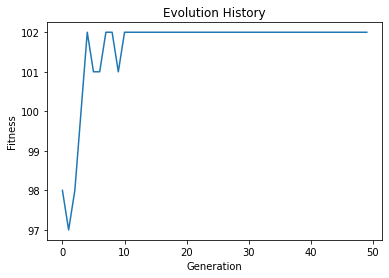

In [20]:
import matplotlib.pyplot as plt

plt.plot(hist.max(axis=1))
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Evolution History")
plt.show()

Looking at the evolution history, we can see that the algorithm was able to quickly converge to the solution.

![Evolution History](3-CNF-SAT-Figure1.jpg)

By comparing the number of times the problem was evaluated, with the number of possible combinations of variables, we can see that he managed to find the solution with some efficiency:

In [14]:
problem.n_test/(2**problem.n_variable)

1.1102230246251565e-13

We can print all the variables of the solution:

In [15]:
problem.print_individual(best)

Individual's fitness: 102 / 102
Variables:
A: False
B: True
C: True
D: False
E: False
F: False
G: False
H: True
I: True
J: True
K: False
L: True
M: False
N: True
O: True
P: True
Q: True
R: True
S: True
T: True
U: True
V: True
W: False
X: True
Y: False
Z: True
a: True
b: True
c: False
d: False
e: True
f: True
g: True
h: True
i: True
j: True
k: True
l: True
m: False
n: True
o: True
p: True
q: True
r: True
s: True
t: True
u: True
v: False
w: True
x: False
y: True
z: False
